# [ Hopefield Network ]
### 1.패턴그룹 3의 숫자를 이용하여 홉필드 프로그램을 작성하였습니다.
### 2.노이즈를 첨가하고, 비동기적인 갱신이 실행될 때마다 출력의 변화를 디스플레이 하였습니다.

In [46]:
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2
import import_ipynb
from keras.utils import np_utils
from PIL import Image

In [47]:
# 호필드 네트워크
class HN():
     
    # 호필드 네트워크를 초기화하는 함수입니다.
    def __init__(self, train_data):
        # 이미지 개수
        self.num = train_data.shape[0]   
        # 이미지의 열의 갯수
        self.col = train_data.shape[1]   
        # 우리가 생성한 이미지를 grayscale 시켜 입력에 알맞은 형태로 만들어줍니다.
        self.train_data = train_data.reshape(train_data.shape[0], 100) / 255.0   
       
        # 가중치 ,임계점, 에너지 
        self.weight = list()         
        self.threshold = list()          
        self.e = 0            
        
    # Threshold를 계산하는 함수입니다.
    def Threshold(self):
        # 반복문을 통해 PDF 임계치 공식을 구현하였습니다.
        for i in range(0, self.weight.shape[0]) :            
            self.threshold.append(-0.5 * sum(self.weight[i]))
            
        return self.threshold
    
        
    # 가중치를 생성 및 계산하는 함수입니다.
    def calculate_Weight(self):
        # 우리는 일단 0과 1로 구성되어 있는 입력데이터를 bipolar형태로 바꾸어 주기 위해서
        # 아래의 문장을 실행합니다.
        # 아래의 공식은 pdf에 나온 공식을 이용하였습니다.
        weight_cal = 2 * self.train_data - 1
        

        # pdf에 나온것처럼 i와 j가 같을 경우 0을 대입합니다.
        # 그렇지 않을 경우 pdf 공식처럼 bipolar 값을 각각 곱하여 시그마를 취해줍니다.
        for r in range(0, weight_cal.shape[0]) :
            weight_list = list()
            
            for i in range(0, weight_cal.shape[1]) :
                for j in range(0, weight_cal.shape[1]) :
                    if (i == j) :
                        weight_list.append(0)
                    else :
                        weight_list.append(weight_cal[r][i] * weight_cal[r][j])
            self.weight.insert(r, weight_list)
        
        # 시그마에 해당하는 부분입니다.
        # 곱한 bipolar 값을 시그마를 취해주는 과정입니다.
        self.weight = np.array(self.weight)
        t = self.weight[0]
        
        # 반복문을 통해 시그마를 구현하였습니다.
        for i in range(1, self.num) :
            t += self.weight[i]
        
        # 가중치를 변경시킵니다.
        self.weight = t
        # 가중치행렬의 모양을 입력데이터에 알맞게 변경시켜 줍니다.
        # 100 x 100
        self.weight = np.array(self.weight).reshape(self.train_data.shape[1], self.train_data.shape[1])
        
        return self.weight
    
    
    # 호필드에서는 에러가 쓰이지 않고 에너지가 사용됩니다
    # 에너지는 낮을 수록 좋으며,그러한 에너지를 계산하는 함수입니다. 
    def calculate_energy(self, unit):
        e = list()
        # 세타 x X 
        theta = np.dot(self.threshold, unit)
        for i in range(0, len(unit)) :
            e.append(np.dot(-0.5 * self.weight[i], unit[i] * unit) + theta)

        self.e = sum(e)
        return self.e

    
    # net값 계산
    def calculate_net(self, unit):
        
        unit = unit[0]
        transpose_weigtht = self.weight.T
        elist = list()
        # 이미지들을 담을 리스트
        imgiplist = list()           
        
        # 반복문을 통해 net 값을 구하고 상태를 업데이트 해주는 부분
        for i in range(0, self.weight.shape[0]) : 
            unit_next = np.dot(unit, transpose_weigtht[i]) + self.threshold[i]
            
            # 해당 결과값이 0보다 큰 경우 1로 설정합니다.
            if (unit_next > 0) :
                unit[i] = 1
            # 해당 결과값이 0보다 작은 경우 0 설정합니다.
            elif (unit_next < 0) : 
                unit[i] = 0
            
            # 비동기적 갱신의 결과를 출력하기 위해서 데이터를 
            # 이전의 형태에 맞게 설정해줍니다. (  greyscale 이미지로 변환 )
            if (i % 25 == 0 or i == 99):
                e = self.calculate_energy(unit)
                elist.append(e)
                show_img = unit.reshape(10, 10) * 255
                imgiplist.append(Image.fromarray(show_img.astype('uint8'), 'L'))      
        
        # 출력할 이미지의 사이즈를 설정해주는 부분
        rows = 1
        cols = 6
        fig = plt.figure(figsize=(13,13))             
             
        # 각각의 이미지에 대한 설정을 지정합니다. 
        for i in range(0, len(imgiplist)):
            ax = fig.add_subplot(rows, cols, i+1)      
            ax.imshow(imgiplist[i])
            ax.set_title("Energy : " + str(elist[i]), fontsize = 10)    
            ax.set_xticks([]), ax.set_yticks([])  
        
        # 이미지 출력
        fig.tight_layout()                            
        plt.show()

        return unit
    

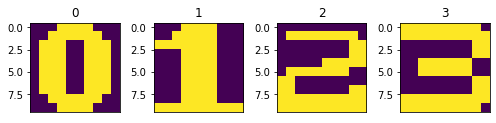

In [48]:
# 입력할 이미지 파일들을 불러옵니다.
folder_path = './num/'
imglist = list()
y_train = list()
labels = ["0", "1", "2", "3"]
label_len = len(labels)

# 이미지를 출력하기전에 각각의 이미지에 대해 GrayScale합니다.
for i in range(label_len):
    imgpath = folder_path + str(i) + '.png'
    img = cv2.imread(imgpath, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(255-img, (10,10))
    imglist.append(img)


# 이미지 크기를 지정합니다.
fig = plt.figure(figsize=(7,7))

# 해당되는 이미지를 출력하기위해 subplot을 추가하고,
# label, fontsize, 여백등을 설정하여 최종 이미지를 출력합니다.
for i in range(0, len(imglist)):
    show_img = fig.add_subplot(1, 4, i+1)
    show_img.imshow(imglist[i])
    show_img.set_title(labels[i], fontsize = 12)
    show_img.set_xticks([]), ax.set_yticks([])

# 이미지 출력
fig.tight_layout()
plt.show()

train_data = np.array(imglist)

In [49]:
# 호필드네트워크에 이전에 가져왔던 파일들을 입력으로 하여 학습을 진행합니다.
hp = HN(train_data)
weight = hp.calculate_Weight()

# threshold를 계산합니다.
thres = hp.Threshold()

In [50]:
# 지정된 %만큼 이미지를 변형하는 함수 - 노이즈 첨가
def insert_noise(data, noise) : 
    data = data.reshape(1, 100) / 255.0
    number = data.shape[1] * noise
    number = int(number)
    
    # 이미지 크기의 %만큼 랜덤적으로 노이즈를 생성합니다.
    for_noise = random.sample(range(0, 100), number)
    
    for i in range(0, len(for_noise)) :
        datan = data[0][for_noise[i]]
        
    # 이미지에 노이즈를 추가합니다.
        if (datan == 0) : 
            datan = 1
        else :
            datan = 0
        data[0][for_noise[i]] = datan
    
    return data

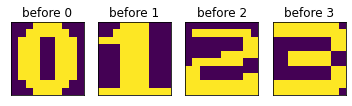

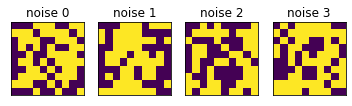

In [51]:
# 지정된 노이즈 수 만큼 이미지 변형
num_list = list()
num_data = list()

datalist = list()
noise_data = list()
datalabel = ["before", "noise"]

# 30%의 노이즈를 첨가하고 grayscale을 적용합니다.
for i in range(0, len(train_data)):
    num_list.append(insert_noise(train_data[i], 0.3))
    num_data.append(num_list[i].reshape(10, 10) * 255)
    datalist.append(Image.fromarray(train_data[i].astype('uint8'), 'L'))   # before_noise -> grayscale 적용
    noise_data.append(Image.fromarray(num_data[i].astype('uint8'), 'L'))    # noise -> grayscale 적용

# 노이즈 첨가 전 이미지 출력

# 이미지 사이즈 설정
fig = plt.figure(figsize=(5, 5))

# 해당되는 이미지를 출력하기위해 subplot을 추가하고,
# label, fontsize, 여백등을 설정하여 최종 이미지를 출력합니다.
for i in range(0, len(datalist)):
    show = fig.add_subplot(1, 4, i+1)
    show.imshow(datalist[i])
    show.set_title(datalabel[0] + " " + str(i), fontsize = 12)
    show.set_xticks([]), show.set_yticks([])

# 이미지 출력
fig.tight_layout()
plt.show()

# noise 이미지 크기 설정
fig = plt.figure(figsize=(5, 5))

# 해당되는 이미지를 출력하기위해 subplot을 추가하고,
# label, fontsize, 여백등을 설정하여 최종 이미지를 출력합니다.
for i in range(0, len(noise_data)):
    show = fig.add_subplot(1, 4, i+1)
    show.imshow(noise_data[i])
    show.set_title(datalabel[1] + " " + str(i), fontsize = 12)
    show.set_xticks([]), show.set_yticks([])

fig.tight_layout()                             # subplot간 간격 겹치지 않게 설정
plt.show()


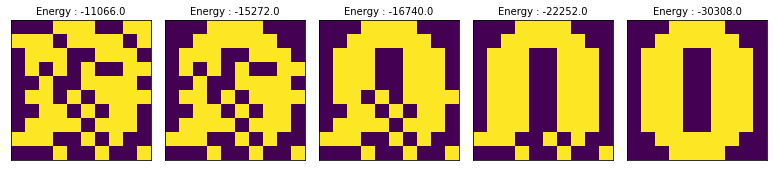

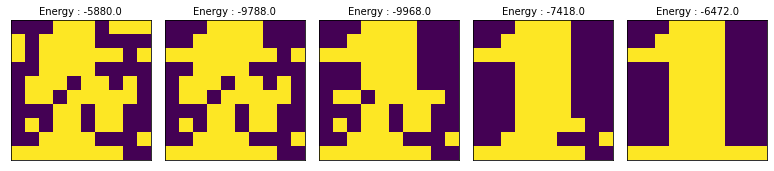

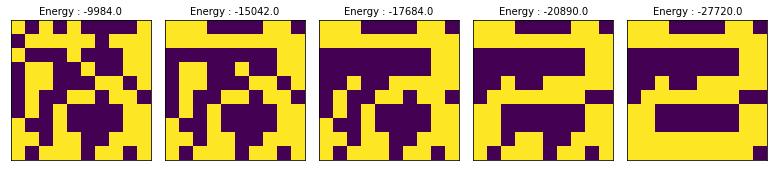

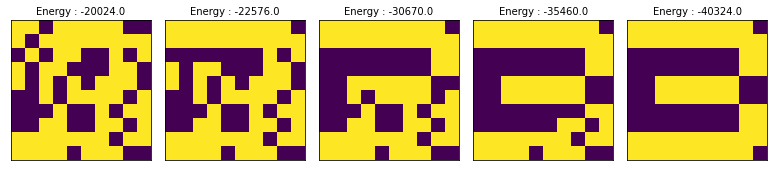

In [52]:
#노이즈가 섞인 숫자를 입력하여 업데이트 하도록 합니다.
noise_data = num_list

for i in range(0, len(noise_data)):
    update_data = hp.calculate_net(noise_data[i])